In [1]:
import xarray as xr
from xclim import sdba
from xclim.core.calendar import convert_calendar
import xclim.indicators as xci
import xclim.ensembles as xce
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import ec3
import gcsfs
import zarr
import os

# lat and lon coordinates for Edmonton
lat_edm = 53.5
lon_edm = -113.5

# time periods for historical and future periods
years_hist = range(1980, 2011) # remember that range(start, end) is not inclusive of `end`
years_future = range(2030, 2061)

# url for the CSV file that contains the data catalog
url_gcsfs_catalog = 'https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv'

In [2]:
# get the same station data used in the previous examples.
# The data file will only exist if you've already run
# the code for 6.1
stn_ds = xr.open_dataset('data_files/station_data_edmonton.nc')
stn_ds_noleap = convert_calendar(stn_ds, 'noleap')
tas_obs_noleap = stn_ds_noleap.tas
stn_lat = float(stn_ds.lat.values)
stn_lon = float(stn_ds.lon.values)

In [3]:
# open the Google Cloud model data catalog with pandas
df_catalog = pd.read_csv(url_gcsfs_catalog)

# search for entries that have daily tas data from the selected scenarios and models
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

model = "MPI-ESM1-2-LR"

search_string = "table_id == 'day' & variable_id == 'tas'"
search_string += f" & experiment_id == {scenarios}"
search_string += f"& source_id == '{model}'"
df_search = df_catalog.query(search_string)

df_search = df_search.sort_values(['experiment_id', 'member_id'])
df_search

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
222401,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r10i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,NaN,20190710
222060,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r1i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,NaN,20190710
234602,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r2i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,NaN,20190710
234208,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r3i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,NaN,20190710
232957,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r4i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,NaN,20190710
235284,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r5i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,NaN,20190710
235429,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r6i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,NaN,20190710
236448,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r7i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,NaN,20190710
232418,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r8i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,NaN,20190710
236208,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r9i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,NaN,20190710


In [4]:
# functions to download the data
def get_and_process_data(catalog_df, model, scenario, member, gcs, lat, lon, years):
    # get the ztore url for this model and scenario
    df_sim = catalog_df.query(f"source_id == '{model}' & experiment_id == '{scenario}' & member_id == '{member}'")
    zstore_url = df_sim.zstore.values[0]
    
    # get the GCS mapper from the url
    mapper = gcs.get_mapper(zstore_url)
    
    # open the file with xarray
    ds = xr.open_zarr(mapper, consolidated = True)
    
    # get the tas data, select the time period, and interp to the desired location
    tas_loc = ds.tas.sel(time = ds.time.dt.year.isin(years)).interp(lat = lat, lon = lon)
    
    # drop 'height' coordinate, which is always 2m but isn't present on all datasets
    if 'height' in tas_loc.coords.keys():
        tas_loc = tas_loc.reset_coords('height', drop = True)
        
    # some datasets put the date at 12:00 whereas some put it at 00:00. To make all
    # of them consistent, simply change the time coordinate to the date only
    tas_loc = tas_loc.assign_coords(time = tas_loc.time.dt.floor('D'))
    # convert from Kelvin to Celsius and return
    
    tas_loc = tas_loc - 273.15
    return tas_loc.compute()

def download_data_multimember_multiscen(catalog_df, gcs, model, scenarios,
                                        stn_lat, stn_lon,
                                        years_hist, years_future):

    ds_list_hist = []
    ds_list_future = []
    members = np.unique(catalog_df.member_id.values)
    for member in members:
        print(f"======================== {member} =============================")
        print('historical')
        tas_model_hist = get_and_process_data(catalog_df, model, 'historical', member,
                                              gcs, stn_lat, stn_lon, years_hist)
        ds_list_hist.append(tas_model_hist)
    
        # get the future simulation data for this model, for each scenario
        ds_list_scen = []
        for scenario in scenarios[1:]: # exclude 'historical' from this iteration
            print(scenario)
            tas_model_future = get_and_process_data(catalog_df, model, scenario, member,
                                                    gcs, stn_lat, stn_lon, years_future)
            ds_list_scen.append(tas_model_future)
    
        # create ensemble for this one model, where the 'realization' dim represents the different scenarios
        ds_future = xce.create_ensemble(ds_list_scen, realizations = scenarios[1:])
    
        # rename the 'realization' dim
        ds_future = ds_future.rename({'realization': 'scenario'})
        ds_list_future.append(ds_future)
    
    print('finished acquiring model data')
    
    # concatenate the ds_lists together
    ds_ens_hist_raw = xce.create_ensemble(ds_list_hist,                             
                                          realizations = members,
                                          calendar = 'noleap')

    ds_ens_future_raw = xce.create_ensemble(ds_list_future, 
                                          realizations = members,
                                          calendar = 'noleap')

    
    # return
    return ds_ens_hist_raw, ds_ens_future_raw

In [5]:
# authenticate access to Google Cloud
gcs = gcsfs.GCSFileSystem(token='anon')

# file names to save the downloaded data, to save time later when re-running this notebook
fout_hist = f'data_files/tas.{model}.daily.historical.1980-2010.edmonton.nc'
fout_future = f'data_files/tas.{model}.daily.ssp1235.2030-2060.edmonton.nc'

# use the function to download the data, this may take a few minutes to run
if (not os.path.exists(fout_hist)) or (not os.path.exists(fout_future)):
    ds_ens_hist_raw, ds_ens_future_raw = download_data_multimember_multiscen(df_search, gcs, model, 
                                                                             scenarios, stn_lat, stn_lon, 
                                                                             years_hist, years_future)

    # write the data to output files 
    ds_ens_hist_raw.to_netcdf(fout_hist)
    ds_ens_future_raw.to_netcdf(fout_future)
else:
    # open the files that already exist
    ds_ens_hist_raw = xr.open_dataset(fout_hist)
    ds_ens_future_raw = xr.open_dataset(fout_future)

In [6]:
# calculate the daily climatology, averaged across models, for the historical and future data
tas_ens_hist_raw = ds_ens_hist_raw.tas
tas_ens_future_raw = ds_ens_future_raw.tas

tas_ensmean_hist_raw_clim = tas_ens_hist_raw.groupby('time.dayofyear').mean(('time', 'realization')).compute()
tas_ensmean_future_raw_clim = tas_ens_future_raw.groupby('time.dayofyear').mean(('time', 'realization')).compute()

# standard deviations for historical 
tas_ensmean_hist_raw_clim_std = tas_ens_hist_raw.groupby('time.dayofyear').std(('time', 'realization')).compute()

# ssp585
tas_ens_ssp5_raw = tas_ens_future_raw.sel(scenario = 'ssp585')
tas_ensmean_ssp5_raw_clim_std = tas_ens_ssp5_raw.groupby('time.dayofyear').std(('time', 'realization')).compute()

# daily climatology for obs
tas_dailyclim_obs = tas_obs_noleap.groupby('time.dayofyear').mean('time').compute()

# add historical and future scenarios to the same DataArray so the xarray plotting routines show it on the legend
tas_ensmean_hist_raw_clim = tas_ensmean_hist_raw_clim.assign_coords(scenario = 'historical')
tas_clim_model_raw = xr.concat([tas_ensmean_hist_raw_clim, tas_ensmean_future_raw_clim],
                                dim = 'scenario')

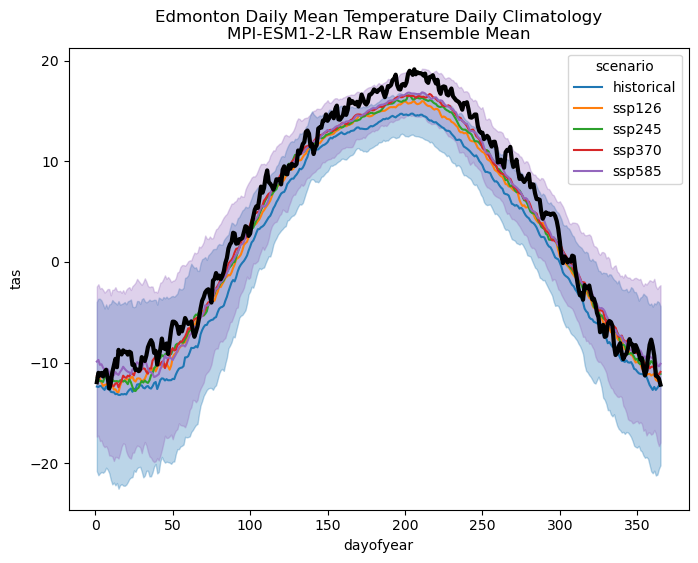

In [7]:
# plot the daily climatologies
fig, ax = plt.subplots(figsize = (8,6))

# daily climatologies as 1D curves
# model
lines = tas_clim_model_raw.plot.line(ax = ax, hue = 'scenario')

# obs
tas_dailyclim_obs.plot.line(ax = ax, label = "Station Obs", color = 'k', linewidth = 3)

# 1 sigma shading
# historical
ax.fill_between(tas_ensmean_hist_raw_clim.dayofyear,
                tas_ensmean_hist_raw_clim - tas_ensmean_hist_raw_clim_std,
                tas_ensmean_hist_raw_clim + tas_ensmean_hist_raw_clim_std,
                alpha = 0.3, color = lines[0].get_color())


# ssp585
ax.fill_between(tas_ensmean_future_raw_clim.dayofyear,
                tas_ensmean_future_raw_clim.sel(scenario = 'ssp585') - tas_ensmean_ssp5_raw_clim_std,
                tas_ensmean_future_raw_clim.sel(scenario = 'ssp585') + tas_ensmean_ssp5_raw_clim_std,
                alpha = 0.3, color = lines[-1].get_color())

title = "Edmonton Daily Mean Temperature Daily Climatology"
title += f"\n{model} Raw Ensemble Mean"
ax.set_title(title)
plt.show()

In [8]:
# calculate effective sample size for historical and future periods
def effective_sample_size(data):
    ntime = len(data.time)
    # times not including the final timestep
    times = data.time.isel(time = slice(0, ntime - 1))
    # data not including the first timestep
    data_lag = data.isel(time = slice(1, ntime))
    # match up time values, otherwise the xr.corr function won't return the correct output
    data_lag = data_lag.assign_coords(time = times)
    
    # calculate correlation
    autocor = xr.corr(data.sel(time = times),
                      data_lag,
                      dim = 'time')
    
    neff = ntime * (1 - autocor) / (1 + autocor)
    
    return neff

# calculate effective sample size and sum across ensemble members, each ens member is independent
neff_hist_raw = effective_sample_size(tas_ens_hist_raw).sum('realization')
neff_future_raw = effective_sample_size(tas_ens_future_raw).sum('realization')

In [9]:
# calculate mean and stdev for raw historical and future tas
tas_ens_hist_raw_mean = tas_ens_hist_raw.mean(('realization', 'time'))
tas_ens_hist_raw_stdev = tas_ens_hist_raw.std(('realization', 'time'))

tas_ens_future_raw_mean = tas_ens_future_raw.mean(('realization', 'time'))
tas_ens_future_raw_stdev = tas_ens_future_raw.std(('realization', 'time'))

# perform two_sample t-test to see if future temperatures are higher than past
pvals = []
for scenario in tas_ens_future_raw_mean.scenario.values:
    tstat, pval = stats.ttest_ind_from_stats(tas_ens_future_raw_mean.sel(scenario = scenario), 
                                            tas_ens_future_raw_stdev.sel(scenario = scenario), 
                                            neff_future_raw.sel(scenario = scenario), 
                                            tas_ens_hist_raw_mean,
                                            tas_ens_hist_raw_stdev,
                                            neff_hist_raw, 
                                            equal_var = False,
                                            alternative = 'greater') 
    pvals.append(pval)

    print('p-values for mean change of raw tas')
pd.DataFrame.from_dict({'scenario': tas_ens_future_raw_mean.scenario.values, 'p-value': np.around(pvals, 4)})

p-values for mean change of raw tas
p-values for mean change of raw tas
p-values for mean change of raw tas
p-values for mean change of raw tas


,scenario,p-value
0,ssp126,0.0001
1,ssp245,0.0000
2,ssp370,0.0000
3,ssp585,0.0000


In [10]:
# assign unit to temperature data
tas_ens_hist_raw.attrs['units'] = 'degC'
tas_ens_future_raw.attrs['units'] = 'degC'
tas_obs_noleap.attrs['units'] = 'degC'

# calculate CDDs
cdd_obs =  xci.atmos.cooling_degree_days(tas_obs_noleap).compute()
cdds_hist_raw = xci.atmos.cooling_degree_days(tas_ens_hist_raw).compute()
cdds_future_raw = xci.atmos.cooling_degree_days(tas_ens_future_raw).compute()

# long-term means 
cdd_obs_ltm = cdd_obs.mean('time')
cdds_hist_raw_ltm = cdds_hist_raw.mean('time')
cdds_future_raw_ltm = cdds_future_raw.mean('time')

# climate change delta
cdds_delta_raw = cdds_future_raw_ltm - cdds_hist_raw_ltm 

# ensemble mean change
cdds_delta_raw_ensmean = cdds_delta_raw.mean('realization')

# represent ensemble spread for each scenario by taking stdev across realizations for the change in long-term means
cdds_delta_raw_ens_spread = cdds_delta_raw.std('realization')



/home/mmorris/miniconda3/envs/UTCDW2/lib/python3.9/site-packages/xclim/core/cfchecks.py:41: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/home/mmorris/miniconda3/envs/UTCDW2/lib/python3.9/site-packages/xclim/core/cfchecks.py:45: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


/home/mmorris/miniconda3/envs/UTCDW2/lib/python3.9/site-packages/xclim/core/cfchecks.py:41: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/home/mmorris/miniconda3/envs/UTCDW2/lib/python3.9/site-packages/xclim/core/cfchecks.py:45: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


/home/mmorris/miniconda3/envs/UTCDW2/lib/python3.9/site-packages/xclim/core/cfchecks.py:41: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/home/mmorris/miniconda3/envs/UTCDW2/lib/python3.9/site-packages/xclim/core/cfchecks.py:45: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


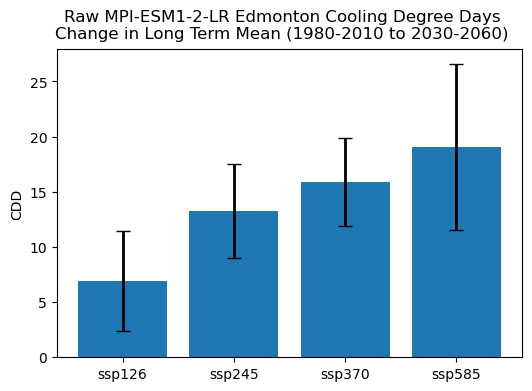

In [11]:
# plot changes to CDDs from the raw model output
fig, ax = plt.subplots( figsize = (6, 4))
fig.suptitle(f"Raw {model} Edmonton Cooling Degree Days\nChange in Long Term Mean (1980-2010 to 2030-2060)")

# plot long-term means
bars = ax.bar(scenarios[1:],cdds_delta_raw_ensmean.values, 
             yerr = cdds_delta_raw_ens_spread.values, 
             capsize = 5, error_kw = {'ecolor': 'k', 'elinewidth': 2})

ax.set_ylabel('CDD')

plt.show()

In [12]:
# spread due to internal variability
cdds_delta_raw_internal_spread_pct = (cdds_delta_raw_ens_spread / cdds_delta_raw_ensmean) * 100
cdds_delta_raw_internal_spread_pct = cdds_delta_raw_internal_spread_pct.rename('pct_internal_spread_raw')

# average across scenario
internal_spread_raw_scen_mean = cdds_delta_raw_internal_spread_pct.mean('scenario')
internal_spread_raw_scen_mean['scenario'] = 'mean'


# print out the results in a table
internal_spread_raw = xr.concat([cdds_delta_raw_internal_spread_pct, internal_spread_raw_scen_mean], dim = 'scenario')
internal_spread_raw = np.around(internal_spread_raw, 2) # round to 2 decimal places
internal_spread_raw.to_dataframe().drop(['lon', 'lat'], axis = 1) 

,pct_internal_spread_raw
scenario,
ssp126,64.98
ssp245,32.17
ssp370,25.26
ssp585,39.44
mean,40.47


In [13]:
# spread across scenarios
cdds_raw_delta_scen_spread = cdds_delta_raw_ensmean.std('scenario')

cdds_delta_raw_scen_spread_pct = (cdds_raw_delta_scen_spread / cdds_delta_raw_ensmean.mean('scenario')) * 100

print(f"Scenario Uncercainty for Raw Model Output: {np.around(cdds_delta_raw_scen_spread_pct.values, 2)}%")

Scenario Uncercainty for Raw Model Output: 32.39%


In [14]:
# fix the time axis chunking so xclim won't complain
tas_ens_hist_raw = tas_ens_hist_raw.chunk({'time': -1})
tas_ens_future_raw = tas_ens_future_raw.chunk({'time': -1})

In [15]:
# train and then apply the QDM bias correction
QDM_trained = sdba.adjustment.QuantileDeltaMapping.train(tas_obs_noleap,     
                                                         tas_ens_hist_raw, 
                                                         nquantiles = 50, 
                                                         kind = "+",
                                                         group = 'time.month' 
                                                         )


tas_ens_hist_qdm = QDM_trained.adjust(tas_ens_hist_raw,                              
                                      interp = 'linear')

tas_ens_future_qdm = QDM_trained.adjust(tas_ens_future_raw,                                 
                                        interp = 'linear')

In [16]:
# calculate daily climatologies for the multi-model ensemble
tas_clim_hist_qdm = tas_ens_hist_qdm.groupby('time.dayofyear').mean(('time' ,'realization')).compute()
tas_clim_future_qdm = tas_ens_future_qdm.groupby('time.dayofyear').mean(('time' ,'realization')).compute()

# stdevs for historical and SSP5-8.5
tas_clim_hist_qdm_stdev = tas_ens_hist_qdm.groupby('time.dayofyear').std(('time' ,'realization')).compute()
tas_clim_ssp5_qdm_stdev = tas_ens_future_qdm.sel(scenario = 'ssp585').groupby('time.dayofyear').std(('time' ,'realization')).compute()

# add historical and future scenarios to the same DataArray so the xarray plotting routines show it on the legend
tas_clim_hist_qdm = tas_clim_hist_qdm.assign_coords(scenario = 'historical')
tas_clim_model_qdm = xr.concat([tas_clim_hist_qdm, tas_clim_future_qdm],
                                dim = 'scenario')

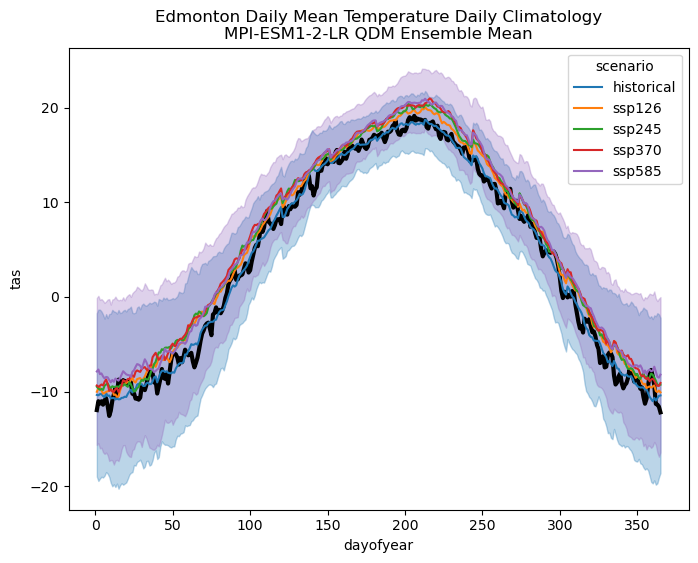

In [17]:
# plot the daily climatologies for all scenarios, QDM
fig, ax = plt.subplots(figsize = (8,6))

# daily climatologies as 1D curves
# obs
tas_dailyclim_obs.plot.line(ax = ax, label = "Station Obs", color = 'k', linewidth = 3)

# models
tas_clim_model_qdm.plot.line(ax = ax, hue = 'scenario')


# 1 sigma shading
# historical
ax.fill_between(tas_clim_hist_qdm.dayofyear,
                tas_clim_hist_qdm - tas_clim_hist_qdm_stdev,
                tas_clim_hist_qdm + tas_clim_hist_qdm_stdev,
                alpha = 0.3, color = lines[0].get_color())


# ssp585
ax.fill_between(tas_clim_future_qdm.dayofyear,
                tas_clim_future_qdm.sel(scenario = 'ssp585') - tas_clim_ssp5_qdm_stdev,
                tas_clim_future_qdm.sel(scenario = 'ssp585') + tas_clim_ssp5_qdm_stdev,
                alpha = 0.3, color = lines[-1].get_color())

ax.set_ylabel('tas')
ax.set_title(f"Edmonton Daily Mean Temperature Daily Climatology\n{model} QDM Ensemble Mean")
plt.show()

In [18]:
# calculate mean and stdev for downscaled historical and future tas
tas_ens_hist_qdm_mean = tas_ens_hist_qdm.mean(('realization', 'time'))
tas_ens_hist_qdm_stdev = tas_ens_hist_qdm.std(('realization', 'time'))

tas_ens_future_qdm_mean = tas_ens_future_qdm.mean(('realization', 'time'))
tas_ens_future_qdm_stdev = tas_ens_future_qdm.std(('realization', 'time'))

# effective sample size
neff_hist_qdm = effective_sample_size(tas_ens_hist_qdm).sum('realization')
neff_future_qdm = effective_sample_size(tas_ens_future_qdm).sum('realization')

# perform two_sample t-test to see if future temperatures are higher than past
pvals = []
for scenario in tas_ens_future_qdm_mean.scenario.values:
    tstat, pval = stats.ttest_ind_from_stats(tas_ens_future_qdm_mean.sel(scenario = scenario), 
                                            tas_ens_future_qdm_stdev.sel(scenario = scenario), 
                                            neff_future_qdm.sel(scenario = scenario), 
                                            tas_ens_hist_qdm_mean,
                                            tas_ens_hist_qdm_stdev,
                                            neff_hist_qdm, 
                                            equal_var = False,
                                            alternative = 'greater') 
    pvals.append(pval)

print('p-values for mean change of QDM tas')
pd.DataFrame.from_dict({'scenario': tas_ens_future_qdm_mean.scenario.values, 'p-value': np.around(pvals, 4)})

p-values for mean change of QDM tas


,scenario,p-value
0,ssp126,0.0001
1,ssp245,0.0000
2,ssp370,0.0000
3,ssp585,0.0000


In [19]:
tas_ens_hist_qdm.attrs['units'] = 'degC'
tas_ens_future_qdm.attrs['units'] = 'degC'

cdds_hist_qdm = xci.atmos.cooling_degree_days(tas_ens_hist_qdm).compute()
cdds_future_qdm = xci.atmos.cooling_degree_days(tas_ens_future_qdm).compute()

# long-term means
cdds_hist_qdm_ltm = cdds_hist_qdm.mean('time')
cdds_future_qdm_ltm = cdds_future_qdm.mean('time')

# climate change deltas
cdds_qdm_delta = cdds_future_qdm_ltm - cdds_hist_qdm_ltm

# ensemble mean delta
cdds_qdm_delta_ensmean = cdds_qdm_delta.mean('realization')

# stdev across ensemble for delta
cdds_qdm_delta_ens_spread = cdds_qdm_delta.std('realization')

/home/mmorris/miniconda3/envs/UTCDW2/lib/python3.9/site-packages/xclim/core/cfchecks.py:41: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/home/mmorris/miniconda3/envs/UTCDW2/lib/python3.9/site-packages/xclim/core/cfchecks.py:45: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


/home/mmorris/miniconda3/envs/UTCDW2/lib/python3.9/site-packages/xclim/core/cfchecks.py:41: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/home/mmorris/miniconda3/envs/UTCDW2/lib/python3.9/site-packages/xclim/core/cfchecks.py:45: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


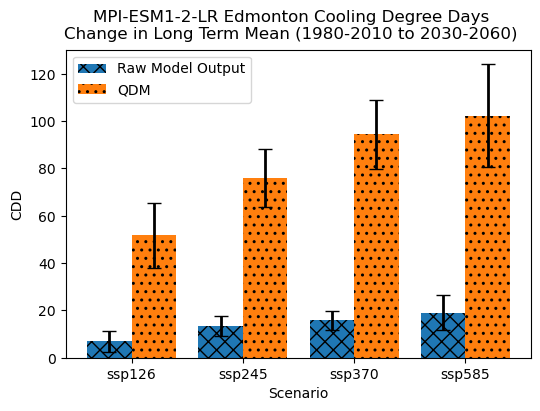

In [20]:
# plot changes to CDDs from QDM data AND raw model data, next to each other
fig, ax = plt.subplots(figsize = (6, 4), sharex = True, sharey = True)
fig.suptitle(f"{model} Edmonton Cooling Degree Days\nChange in Long Term Mean (1980-2010 to 2030-2060)")

# dummy x-axis values, which will be replaced by the scenario names later on.
# we need to use these in order to have the bars for the two scenarios side-by-side
# on the same axis
xx = np.arange(len(scenarios[1:]))
width = 0.4

# raw model changes
bars_raw = ax.bar(xx, cdds_delta_raw_ensmean.values, width, 
                  yerr = cdds_delta_raw_ens_spread.values, 
                   # add hatching to make the two bars differ visually in another way than just the colour.
                   # this helps make the plots more colorblind-friendly
                  label = "Raw Model Output", hatch = 'xx',
                  capsize = 5, error_kw = {'ecolor': 'k', 'elinewidth': 2})

# QDM changes, plotted immediately to the right of the raw changes for the same scenario
bars_qdm = ax.bar(xx + width, cdds_qdm_delta_ensmean.values, width, 
                  yerr = cdds_qdm_delta_ens_spread.values, 
                  label = "QDM", hatch = '..',
                  capsize = 5, error_kw = {'ecolor': 'k', 'elinewidth': 2})


# set up the x-tick labels (scenario names) to be in the middle of the two bars
ax.set_xticks(xx + width/2)
ax.set_xticklabels(scenarios[1:])

# axis labels and legend 
ax.set_ylabel('CDD')
ax.set_xlabel('Scenario')
ax.legend()

plt.show()

In [21]:
# spread due to internal variability
cdds_delta_qdm_internal_spread_pct = (cdds_qdm_delta_ens_spread / cdds_qdm_delta_ensmean) * 100
cdds_delta_qdm_internal_spread_pct = cdds_delta_qdm_internal_spread_pct.rename('pct_internal_spread_qdm')

# average across scenario
internal_spread_qdm_scen_mean = cdds_delta_qdm_internal_spread_pct.mean('scenario')
internal_spread_qdm_scen_mean['scenario'] = 'mean'


# print out the results in a table
internal_spread_qdm = xr.concat([cdds_delta_qdm_internal_spread_pct, internal_spread_qdm_scen_mean], dim = 'scenario')
internal_spread_qdm = np.around(internal_spread_qdm, 2) # round to 2 decimal places
internal_spread_qdm.to_dataframe().drop(['lon', 'lat'], axis = 1) 

,pct_internal_spread_qdm
scenario,
ssp126,26.47
ssp245,16.04
ssp370,15.47
ssp585,21.18
mean,19.79


In [22]:
cdds_qdm_delta_scen_spread = cdds_qdm_delta_ensmean.std('scenario')
cdds_delta_qdm_scen_spread_pct = (cdds_qdm_delta_scen_spread / cdds_qdm_delta_ensmean.mean('scenario')) * 100

print(f"Scenario Uncercainty After Bias-Adjustment: {np.around(cdds_delta_qdm_scen_spread_pct.values, 2)}%")

Scenario Uncercainty After Bias-Adjustment: 24.02%


In [23]:
cdd_change_10p = cdds_qdm_delta_ensmean.quantile(0.1, dim = 'scenario')
cdd_change_90p = cdds_qdm_delta_ensmean.quantile(0.9, dim = 'scenario')

# ensemble mean historical CDDs
cdds_hist_qdm_ltm_ensmean = cdds_hist_qdm_ltm.mean('realization')

results_str = f"Likely Range of Mean CDD Change from 1980-2010 to 2030-2060 as projected by {model}: "
results_str += f"{int(np.around(100 * cdd_change_10p.values/cdds_hist_qdm_ltm_ensmean.values, 0))}% to "
results_str +=f"{int(np.around(100 * cdd_change_90p.values/cdds_hist_qdm_ltm_ensmean.values, 0))}%"

print(results_str)

Likely Range of Mean CDD Change from 1980-2010 to 2030-2060 as projected by MPI-ESM1-2-LR: 69% to 117%
